In [1]:
from itertools import islice
import time

# import multiprocessing
# multiprocessing.set_start_method('fork')

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["monospace"]
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["figure.figsize"] = (6, 4)
import numpy as np
import networkx as nx
from networkx.classes.function import path_weight
from scipy.optimize import curve_fit

from tqdm import tqdm

In [2]:
def path_to_bit_rep(p, G):
    p = [(v, p[i+1]) for i, v in enumerate(p[:-1])]
    
    bit_rep = []
    for e in G.edges():
        if (e[0], e[1]) in p:
            bit_rep.append(1)
        else:
            bit_rep.append(0)
    
    return np.array(bit_rep)


def compute_dH(p0, p1, G):
    p0 = path_to_bit_rep(p0, G)
    p1 = path_to_bit_rep(p1, G)
    
    return np.abs(p0 - p1).sum()


def sp(ns, W):
    G = nx.grid_2d_graph(2, ns+1)
    G = nx.DiGraph(G)
    for edge in G.copy().edges():
        if edge != tuple(sorted(edge)):
            G.remove_edge(*edge)

    source = (0, 0)
    target = (1, ns)

    for i, e in enumerate(G.edges()):
        G[e[0]][e[1]]['weight'] = W[i]

    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))
    delta = path_weight(G, p1, weight="weight") - path_weight(G, p0, weight="weight")
#     dH = compute_dH(p0, p1, G)

    return delta # , dH

In [3]:
paths = np.zeros(100)
for ns in range(1, 101):
    G = nx.grid_2d_graph(3, ns+1)
    G = nx.DiGraph(G)
    for edge in G.copy().edges():
        if edge != tuple(sorted(edge)):
            G.remove_edge(*edge)

    paths[ns-1] = len(list(nx.all_simple_paths(G, (0, 0), (2, ns))))

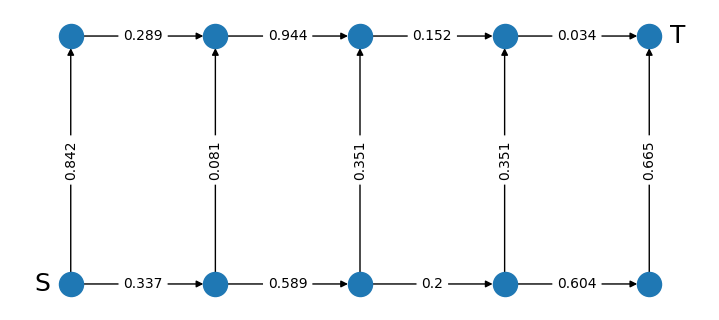

In [4]:
ns = 4
G = nx.grid_2d_graph(2, ns+1)
G = nx.DiGraph(G)
for edge in G.copy().edges():
    if edge != tuple(sorted(edge)):
        G.remove_edge(*edge)

pos = {}
for i in range(5):
    pos[(0, i)] = np.array([i, 0.])
    pos[(1, i)] = np.array([i, 1])

labels = {(0, 0):"S", (1, 4):"T"}

plt.figure(figsize=(7, 3))
nx.draw(G, pos=pos)
pos[(0, 0)] = (-0.2, 0)
pos[(1, 4)] = (4.2, 1)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=18)
pos = {}
for i in range(5):
    pos[(0, i)] = np.array([i, 0.])
    pos[(1, i)] = np.array([i, 1])
W = np.random.random(G.number_of_edges())
W = np.round(W, 3)
labels = {e: W[i] for i, e in enumerate(G.edges)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);
# plt.savefig("ladderW.pdf")

In [5]:
datadir = "data/row/A=N2"

In [6]:
ns_max = 13

to_compute = False
if to_compute:
    M = 10000

    df = np.zeros((ns_max, 2))
    for ns in range(1, ns_max+1):
        N = 4 + 3*(ns-1)
        dfM = np.zeros(M)
        W = np.random.rand(N, M)
        if "Ng" in datadir:
            W = np.random.randn(N, M) / 7 + 0.5 
            W[W < 0] = 0
            W[W > 1] = 1
        for m in tqdm(range(M)):
            dfM[m] = sp(ns, W[:, m])
        df[ns-1] = (dfM.mean(), dfM.std(ddof=1) / M**0.5)

    if "N2" in datadir:
        np.save(f"data/row/A=N/deltaF.npy", df)
    else:
        np.save(f"{datadir}/deltaF.npy", df)

if "N2" in datadir:
    delta_f = np.load("data/row/A=N/deltaF.npy")
else:
    delta_f = np.load(f"{datadir}/deltaF.npy")
    
if "Ng" in datadir:
    df = np.load("data/row/rowG.npy")
else:
    df = np.load("data/row/row.npy")

[0.80086034 0.90286863 0.23966397]
[0.0423995  0.04311187 0.00398962]


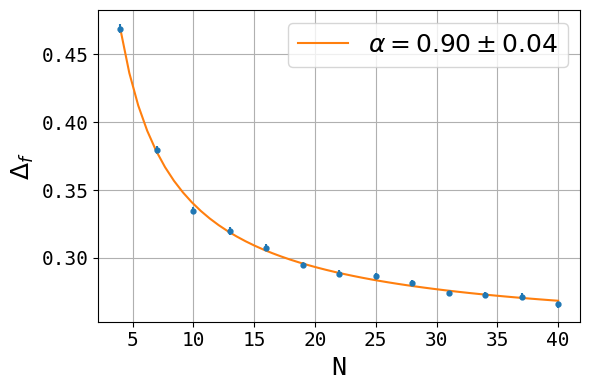

In [7]:
f_fit = lambda x, a, b, c: a / x**b + c

N = [4 + 3*(ns-1) for ns in range(1, ns_max+1)]
x = np.linspace(N[0], max(N))

plt.errorbar(N, delta_f[:, 0], yerr=delta_f[:, 1], fmt=".", ms=7)
popt, pcov = curve_fit(f_fit, N, delta_f[:, 0], sigma=delta_f[:, 1], p0=[0.1, 1, 0.01], maxfev=10000,
                       bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

plt.plot(x, f_fit(x, *popt), label=f"$\\alpha = {popt[1]:.2f} \pm {np.sqrt(pcov[1,1]):.2f}$")
plt.xlabel("N", fontsize=18)
plt.ylabel("$\Delta_f$", fontsize=18)
print(popt)
print(np.sqrt(np.diag(pcov)))
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 18})

if "Ng" in datadir:
    file = "plots/row_deltafG.pdf"
else:
    file = "plots/row_deltaf.pdf"
plt.tight_layout()
# plt.savefig(file)

[0.25750165 0.01981802]
[0.00682696 0.00348919]


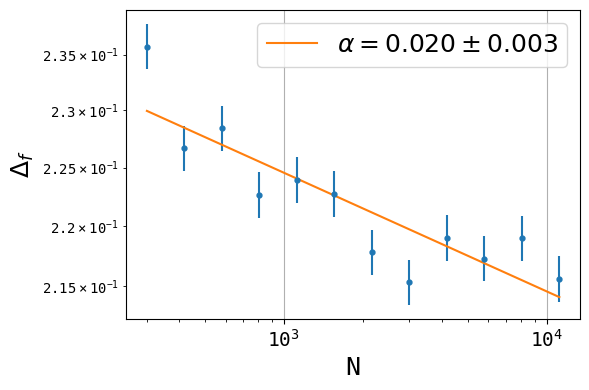

In [8]:
f_fit = lambda x, a, b: a / x**b

N = df[:, 0]
x = np.linspace(N[0], max(N))

plt.errorbar(N, df[:, 1], yerr=df[:, 2], fmt=".", ms=7)
popt, pcov = curve_fit(f_fit, N, df[:, 1], sigma=df[:, 2], p0=[0.2, 1], maxfev=10000,
                       bounds=([0, 0], [np.inf, np.inf]))

plt.plot(x, f_fit(x, *popt), label=f"$\\alpha = {popt[1]:.3f} \pm {np.sqrt(pcov[1,1]):.3f}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("N", fontsize=18)
plt.ylabel("$\Delta_f$", fontsize=18)
plt.legend(prop={'size': 18})
plt.grid()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if "Ng" in datadir:
    file = "plots/row_dfG.pdf"
else:
    file = "plots/row_df.pdf"
plt.tight_layout()
# plt.savefig(file)

print(popt)
print(np.sqrt(np.diag(pcov)))

In [9]:
import h5py

sc = np.zeros((ns_max, 2))
dmin = np.zeros((ns_max, 2))
overlap = np.zeros((ns_max, 2))

for ns in range(ns_max):
    f = h5py.File(f"{datadir}/ns={ns+1}.jld", "r")
    scM, dminM = np.array(f["scM"]), np.array(f["dminM"])
    overlapM = np.array(f["overlapM"])

    scM = scM[(scM != 0) & (overlapM > 0.01)]
    dminM = dminM[(dminM != 0) & (overlapM > 0.01)]
    overlapM = overlapM[(overlapM != 0) & (overlapM > 0.01)]
    M = scM.shape[0]
    print(M)

    sc[ns] = np.mean(scM), np.std(scM, ddof=1) / np.sqrt(M) 
    dmin[ns] = np.mean(dminM), np.std(dminM, ddof=1) / np.sqrt(M)
    overlap[ns] = np.mean(overlapM), np.std(overlapM, ddof=1) / np.sqrt(M)

2500
2500
2500
2500
2500
1250
1250
1250
1239
1237
976
967
979


In [10]:
N = np.array([4 + 3*(ns-1) for ns in range(1, ns_max+1)])

B = 1
A = N.copy()
if "N2" in datadir:
    A = N**2

first_order = np.zeros(delta_f.shape)
first_order[:, 0] = 2 * B*delta_f[:, 0] / (B*delta_f[:, 0] + A+2)
first_order[:, 1] = 2*(A+2) / (B*delta_f[:, 0] + A+2)**2 * B*delta_f[:, 1]

[1.41843715e+00 1.89571762e+00 3.24972019e-04]
[3.92091684e-02 1.37284848e-02 5.54666025e-05]


[1.08713101e+00 2.21351806e+00 2.66269054e-05]
[1.50627005e-02 6.15632992e-03 4.37115400e-06]


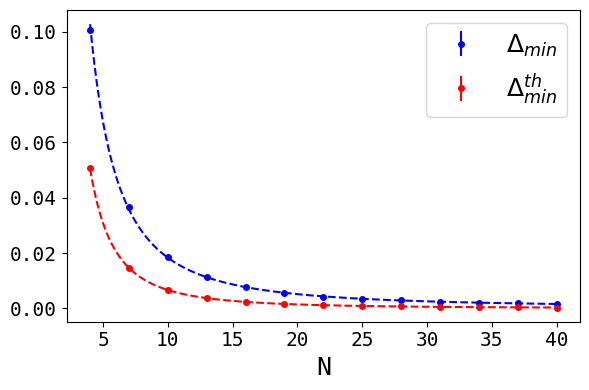

In [11]:
f_fit = lambda x, a, b, c: a / x**b + c

x = np.linspace(N[0], N[-1], 1000)

# plt.figure(figsize=(8, 6))
plt.errorbar(N, dmin[:, 0], yerr=dmin[:, 1], fmt=".", ms=8, 
             c="blue", label="$\Delta_{min}$")

popt, pcov = curve_fit(f_fit, N, dmin[:, 0], sigma=dmin[:, 1], p0=[0.3, 0.05, 0.8],
                       absolute_sigma=True, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
plt.plot(x, f_fit(x, *popt), ls="--", c="blue")
print(popt)
print(np.sqrt(np.diag(pcov)))
print("\n")


x = np.linspace(N[0], N[-1], 1000)
popt, pcov = curve_fit(f_fit, N, first_order[:, 0], sigma=first_order[:, 1], p0=[0.3, 0.05, 0.8],
                       absolute_sigma=True, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
plt.plot(x, f_fit(x, *popt), ls="--", c="red")
print(popt)
print(np.sqrt(np.diag(pcov)))

plt.errorbar(N, first_order[:, 0], yerr=first_order[:, 1], fmt=".", ms=8, 
             c="red", label="$\Delta_{min}^{th}$")

plt.xlabel("N", fontsize=18)
plt.legend(prop={'size': 18})
# plt.grid()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if "Ng" in datadir:
    file = "plots/row_dminG.pdf"
elif "N2" in datadir:
    file = "plots/row_dminN2.pdf"
else:
    file = "plots/row_dmin.pdf"

plt.tight_layout()
# plt.savefig(file)

[5.40613154e-01 1.67522375e+00 1.55368105e-04]
[2.77857359e-02 2.48411417e-02 7.16591450e-05]


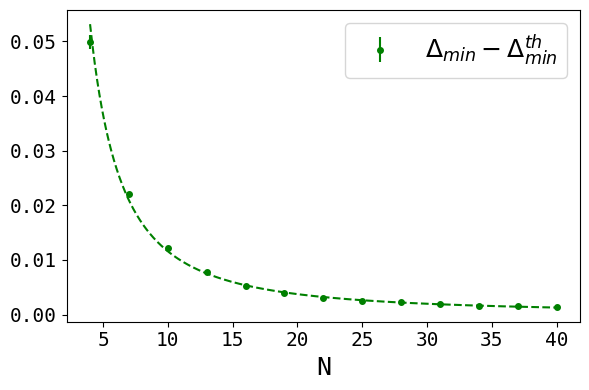

In [12]:
f_fit = lambda x, a, b, c: a / x**b + c

dd = dmin[:, 0] - first_order[:, 0]
dd_err = np.sqrt(dmin[:, 1]**2 + first_order[:, 1]**2)
plt.errorbar(N, dd, yerr=dd_err, fmt=".", ms=8, 
             label="$\Delta_{min} - \Delta_{min}^{th}$", c="green")

popt, pcov = curve_fit(f_fit, N, dd, sigma=dd_err, p0=[0.3, 0.5, 2], absolute_sigma=True, maxfev=5000)
x = np.linspace(N[0], N[-1], 1000)
plt.plot(x, f_fit(x, *popt), c="green", ls="--")
print(popt)
print(np.sqrt(np.diag(pcov)))

plt.xlabel("N", fontsize=18)

plt.legend(prop={'size': 18})
# plt.grid()

if "Ng" in datadir:
    file = "plots/row_ddminG.pdf"
elif "N2" in datadir:
    file = "plots/row_ddminN2.pdf"
else:
    file = "plots/row_ddmin.pdf"

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
# plt.savefig(file)

3.049794591003201 1.6035554701298285 4.0685468896042885
[0.08443245 0.00884695 0.28728715]
2.009330944354789 2.0012916841025166 2.523990546144306
[0.05894369 0.00909392 0.43339021]


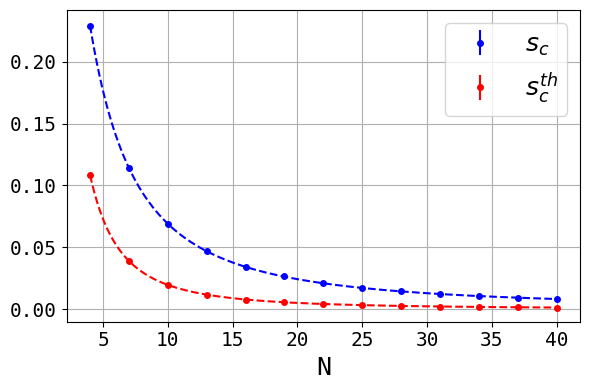

In [13]:
f_fit = lambda x, a, b, c: a / (x**b + c)

plt.errorbar(N, sc[:, 0], fmt='.', yerr=sc[:, 1], label="$s_c$", c="blue", ms=8)

x = np.linspace(N[0], N[-1], 200)
popt, pcov = curve_fit(f_fit, N, sc[:, 0], maxfev=10000,
                       sigma=sc[:, 1], p0=[0.1, 1, 0.1], absolute_sigma=True,
                       bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
print(np.sqrt(np.diag(pcov)))
plt.plot(x, f_fit(x, *popt), c="blue", ls="--")

sc_first = first_order[:, 0] / delta_f[:, 0]
dsc_first = np.sqrt((first_order[:, 1]/first_order[:, 0])**2 + (delta_f[:, 1]/delta_f[:, 0])**2) * sc_first

popt, pcov = curve_fit(f_fit, N, sc_first, maxfev=10000,
                       sigma=dsc_first, p0=[1, 0.1, 0.1], absolute_sigma=True,
                       bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
print(np.sqrt(np.diag(pcov)))
plt.plot(x, f_fit(x, *popt), c="red", ls="--")

plt.errorbar(N, sc_first, yerr=dsc_first, fmt='.', label="$s_c^{th}$", c="red", ms=8)

plt.legend(prop={'size': 18})
plt.xlabel("N", fontsize=18)
plt.grid()

if "Ng" in datadir:
    file = "plots/row_scG.pdf"
elif "N2" in datadir:
    file = "plots/row_scN2.pdf"
else:
    file = "plots/row_sc.pdf"

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
# plt.savefig(file)

[ 0.57127936  1.02961758 -0.00629593]
[0.01502232 0.01465198 0.00042545]


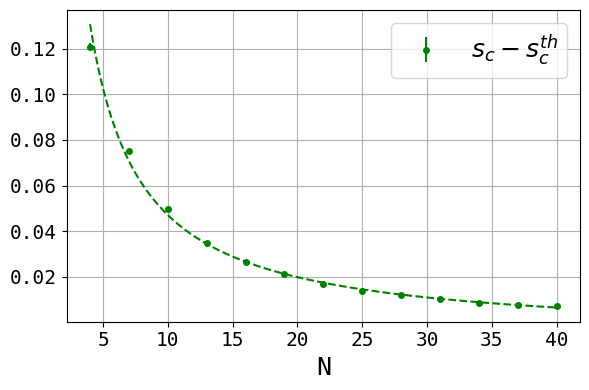

In [14]:
f_fit = lambda x, a, b, c: a / x**b + c

d_sc = sc[:, 0] - sc_first
dd_sc = np.sqrt(sc[:, 1]**2 + dsc_first**2)
if "N2" in datadir:
    fmt = "."
else:
    fmt = ".-"
plt.errorbar(N, d_sc, yerr=dd_sc, fmt=fmt, label="$s_c - s_c^{th}$",
            c="green", ms=8)

plt.legend(prop={'size': 18})
plt.xlabel("N", fontsize=18)
plt.tight_layout

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

if "Ng" in datadir:
    file = "plots/row_dscG.pdf"
elif "N2" in datadir:
    popt, pcov = curve_fit(f_fit, N, d_sc, sigma=dd_sc, p0=[0.3, 0.5, 2], absolute_sigma=True, maxfev=5000)
    
    x = np.linspace(N[0], N[-1], 1000)
    plt.plot(x, f_fit(x, *popt), c="green", ls="--")
    print(popt)
    print(np.sqrt(np.diag(pcov)))

    file = "plots/row_dscN2.pdf"
else:
    file = "plots/row_dsc.pdf"

plt.tight_layout()
# plt.savefig(file)

In [15]:
np.save(f"{datadir}/N.npy", N)
np.save(f"{datadir}/sc.npy", sc)
np.save(f"{datadir}/dmin.npy", dmin)
np.save(f"{datadir}/ddmin.npy", np.vstack((dd, dd_err)).T)
np.save(f"{datadir}/dsc.npy", np.vstack((d_sc, dd_sc)).T)

[1.41843715e+00 1.89571762e+00 3.24972019e-04]
[3.92091684e-02 1.37284848e-02 5.54666025e-05]


[1.08713101e+00 2.21351806e+00 2.66269054e-05]
[1.50627005e-02 6.15632992e-03 4.37115400e-06]


[5.40613154e-01 1.67522375e+00 1.55368105e-04]
[2.77857359e-02 2.48411417e-02 7.16591450e-05]


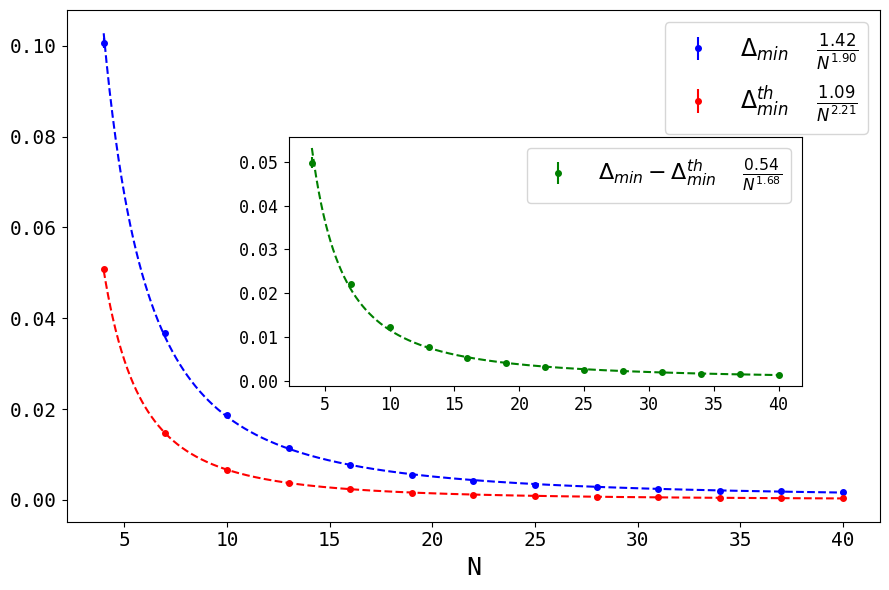

In [16]:
f_fit = lambda x, a, b, c: a / x**b + c

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(f_fit, N, dmin[:, 0], sigma=dmin[:, 1], p0=[0.3, 0.05, 0.8],
                       absolute_sigma=True, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x, f_fit(x, *popt), ls="--", c="blue")
ax.errorbar(N, dmin[:, 0], yerr=dmin[:, 1], fmt=".", ms=8, 
             c="blue", label=f"$\Delta_{{min}}$  $\\frac{{{popt[0]:.2f}}}{{N^{{{popt[1]:.2f}}}}}$")

print(popt)
print(np.sqrt(np.diag(pcov)))
print("\n")

x = np.linspace(N[0], N[-1], 1000)
popt, pcov = curve_fit(f_fit, N, first_order[:, 0], sigma=first_order[:, 1], p0=[0.3, 0.05, 0.8],
                       absolute_sigma=True, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
ax.plot(x, f_fit(x, *popt), ls="--", c="red")
print(popt)
print(np.sqrt(np.diag(pcov)))
print("\n")

ax.errorbar(N, first_order[:, 0], yerr=first_order[:, 1], fmt=".", ms=8, 
             c="red", label=f"$\Delta_{{min}}^{{th}}$  $\\frac{{{popt[0]:.2f}}}{{N^{{{popt[1]:.2f}}}}}$")

ax.set_xlabel("N", fontsize=18)

ax.tick_params(axis='both', labelsize=14)

ax1 = ax.inset_axes([13, 0.025, 25, 0.055], transform=ax.transData)

popt, pcov = curve_fit(f_fit, N, dd, sigma=dd_err, p0=[0.3, 0.5, 2], absolute_sigma=True, maxfev=5000)
print(popt)
print(np.sqrt(np.diag(pcov)))

ax1.errorbar(N, dd, yerr=dd_err, fmt=".", ms=8, 
             label=f"$\Delta_{{min}} - \Delta_{{min}}^{{th}}$  $\\frac{{{popt[0]:.2f}}}{{N^{{{popt[1]:.2f}}}}}$", c="green")

x = np.linspace(N[0], N[-1], 1000)
ax1.plot(x, f_fit(x, *popt), c="green", ls="--")
ax1.legend()
ax1.tick_params(axis='both', labelsize=12)

ax1.legend(prop={'size': 16})
ax.legend(prop={'size': 17})
plt.tight_layout()
plt.savefig("plots/dminN2.pdf")

3.049794591003201 1.6035554701298285 4.0685468896042885
[0.08443245 0.00884695 0.28728715]
2.0093309452590242 2.001291684238962 2.523990553202236
[0.05894368 0.00909392 0.43339011]
0.5712793621172323 1.0296175770813496 -0.0062959288282210864
[0.01502232 0.01465198 0.00042545]


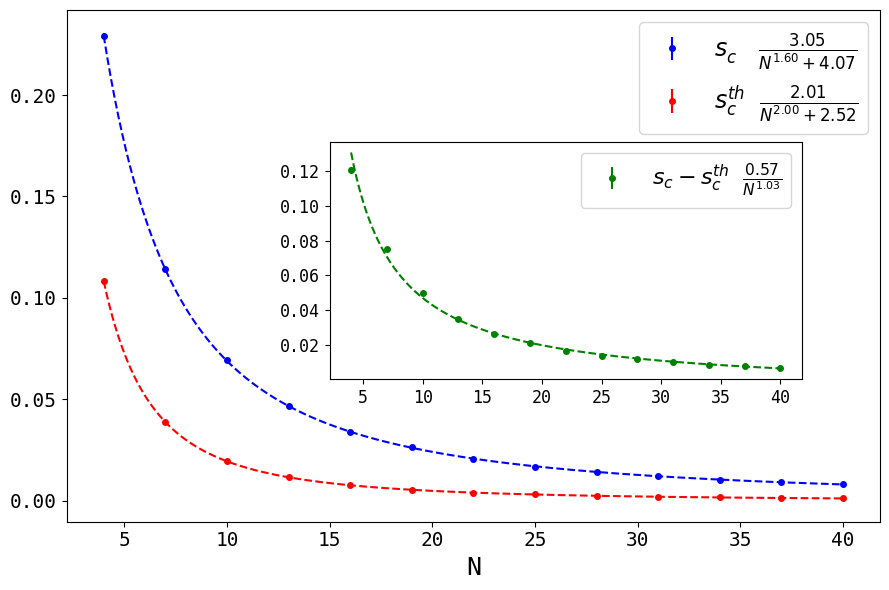

In [17]:
f_fit = lambda x, a, b, c: a / (x**b + c)

fig, ax = plt.subplots(figsize=(9,6))

popt, pcov = curve_fit(f_fit, N, sc[:, 0], maxfev=10000,
                       sigma=sc[:, 1], p0=[0.1, 1, 0.1], absolute_sigma=True,
                       bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
print(np.sqrt(np.diag(pcov)))

ax.errorbar(N, sc[:, 0], fmt='.', yerr=sc[:, 1], label=f"$s_c^{{\\ \\ \\ }}$ $\\frac{{{popt[0]:.2f}}}{{N^{{{popt[1]:.2f}}} + {popt[2]:.2f}}}$", c="blue", ms=8)

x = np.linspace(N[0], N[-1], 200)
ax.plot(x, f_fit(x, *popt), c="blue", ls="--")

sc_first = first_order[:, 0] / delta_f[:, 0]
dsc_first = np.sqrt((first_order[:, 1]/first_order[:, 0])**2 + (delta_f[:, 1]/delta_f[:, 0])**2) * sc_first

popt, pcov = curve_fit(f_fit, N, sc_first, maxfev=10000,
                       sigma=dsc_first, p0=[1, 1, 0.1], absolute_sigma=True,
                       bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
print(np.sqrt(np.diag(pcov)))
ax.plot(x, f_fit(x, *popt), c="red", ls="--")

ax.errorbar(N, sc_first, yerr=dsc_first, fmt='.', label=f"$s_c^{{th}}$ $\\frac{{{popt[0]:.2f}}}{{N^{{{popt[1]:.2f}}} + {popt[2]:.2f}}}$", c="red", ms=8)

ax.legend(prop={'size': 17})
ax.set_xlabel("N", fontsize=18)
# ax.grid()

if "Ng" in datadir:
    file = "plots/row_scG.pdf"
elif "N2" in datadir:
    file = "plots/row_scN2.pdf"
else:
    file = "plots/row_sc.pdf"

ax.tick_params(axis='both', labelsize=14)

ax1 = ax.inset_axes([15, 0.06, 23, 0.117], transform=ax.transData)

f_fit = lambda x, a, b, c: a / x**b + c
popt, pcov = curve_fit(f_fit, N, d_sc, sigma=dd_sc, p0=[0.3, 0.5, 0.1], absolute_sigma=True, maxfev=5000)
print(*popt)
print(np.sqrt(np.diag(pcov)))

ax1.errorbar(N, d_sc, yerr=dd_sc, fmt=fmt, label=f"$s_c - s_c^{{th}}$ $\\frac{{{popt[0]:.2f}}}{{N^{{{popt[1]:.2f}}}}}$",
            c="green", ms=8)

x = np.linspace(N[0], N[-1], 1000)
ax1.plot(x, f_fit(x, *popt), c="green", ls="--")
ax1.legend(prop={'size': 16})
ax1.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig("plots/scN2.pdf")